## Calculate Modified ERA Initial Profiles

#### This code is written by Ehsan Erfani. Most of scientific methods are outlined by Peter Blossey. Some of Peter's Matlab calculations are translated to Python by Ehsan 

In [326]:
import numpy as np # linear algebra
import os
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series, DataFrame
from netCDF4 import Dataset
from math import log10
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.optimize import fsolve
from scipy.optimize import fmin

In [327]:
##### read various files and variables
file        = Dataset('../OUT_STAT/CSET_RF06_Tr2p3_96sqx432_100m_M2005PA_RRTM4PBL_UM5_ProgAer_MERRA2loglogMBL.nc')
forcing     = Dataset('../CSET_RF06_Tr2p3/Forcings_CSET_rf06_traj2p3_v1p2_2021-01-08_MERRA2loglogMBL.nc')
ERA_data    = Dataset('/home/disk/eos7/bloss/Runs/CSET/Data/RF06_Tr2p3/rf06_ERA_data_2.3.nc')
MERRA_data  = Dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/old/rf06_72h_forward_2.3.nc')
MERRA_datab = Dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/old/rf06_48h_backward_2.3.nc')

# Define parameters
casename  = 'CSET-RF06-Tr2.3-3D-Lx10-FTMERRA-loglogMBL'
init_time = '2015-07-17 00Z' 
Obs_jump  = 18
ylim      = 3000

In [388]:
###### Read various satellite and reanalysis ########
## Only initial time!
## Forcing height
ERA_z   =  forcing.variables['z'][0,1:,0,0]      # Geopotential height from ERA-5:
p_interp=  forcing.variables['lev'][1:]          # air pressure

### Functions to read a variable from forward and backward files and concatenate them
def read_var_1D(var_name):
    var = np.concatenate( ( MERRA_datab.variables[var_name][(-Obs_jump+1):], \
                              MERRA_data.variables[var_name][:]), axis=0)
    return var

def read_var_2D(var_name):
    var = np.concatenate( ( MERRA_datab.variables[var_name][(-Obs_jump+1):,:], \
                              MERRA_data.variables[var_name][:]), axis=0)
    return var


### SSMI and MODIS
SSMI_lwp     = read_var_1D('SSMI_LWP') * 1000  # Cloud Liquid Water: converted to g /m2
idx          = np.where(np.isnan(SSMI_lwp) == 0)[0][0]
SSMI_lwp     = SSMI_lwp[idx]
SSMI_lwp_std = read_var_1D('SSMI_LWP_std') * 1000 # Cloud Liquid Water standard deviation over box: mm
MODIS_cth_std= read_var_1D('MODIS_CTH_std') * 1000   # MODIS cloud top height: converted to m
MODIS_cth    = read_var_1D('MODIS_CTH') * 1000   # MODIS cloud top height: converted to m
idx          = np.where(np.isnan(MODIS_cth) == 0)[0][0]
MODIS_cth    = MODIS_cth[idx]
### Time
MERRA_time2  = np.concatenate( ( (MERRA_datab.variables['time'][(-Obs_jump+1):] - MERRA_datab.variables['time'][-Obs_jump+1]) / 24, \
                              (MERRA_data.variables['time'][:] + Obs_jump) / 24), axis=0)
                                #time of measurement: seconds since 2015-07-17T17:00:00+00:00
### MERRA
MERRA_RHO       = read_var_2D('MERRA_AIRDENS')[1,:]    # air_density: kg/m3                     
MERRA_H         = read_var_2D('MERRA_H')[1,:]    # mid_layer_heights

### ERA
ERA_z2    = read_var_2D('ERA_z')[1,:] / 10      # geopotential: converted from m**2 s**-2 to m
ERA_t2    = read_var_2D('ERA_t')[1,:]           # air_temperature: K
ERA_q2    = read_var_2D('ERA_q')[1,:] * 1000    # specific_humidity: converted to g/kg
ERA_r2    = read_var_2D('ERA_r')[1,:]           # relative_humidity: %
ERA_crwc2 = read_var_2D('ERA_crwc')[1,:] * 1000 # Specific rain water content: converted to g kg**-1
ERA_clwc2 = read_var_2D('ERA_clwc')[1,:] * 1000 # Specific cloud water content: converted to g kg**-1
ERA_p2    = MERRA_data.variables['level']       # air_pressure: mb

# interpolate from ERA5 coarse vertical grid to fine grid:
def interp_to_forc_Z(ERA_z2, ERA_var, ERA_z):
    f = interpolate.interp1d(ERA_z2, ERA_var)
    output = f(np.array(ERA_z))
    return output

ERA_t    = interp_to_forc_Z(ERA_z2, ERA_t2, ERA_z)
ERA_q    = interp_to_forc_Z(ERA_z2, ERA_q2, ERA_z)
ERA_r    = interp_to_forc_Z(ERA_z2, ERA_r2, ERA_z)
ERA_p    = interp_to_forc_Z(ERA_z2, ERA_p2, ERA_z)
ERA_crwc = interp_to_forc_Z(ERA_z2, ERA_crwc2, ERA_z)
ERA_clwc = interp_to_forc_Z(ERA_z2, ERA_clwc2, ERA_z)

ERA_lwc  = ERA_crwc + ERA_clwc             # liquid water mixing ratio (rain water + liquid cloud water)
ERA_qt   = ERA_q + ERA_lwc                 # Total water: g/kg


# interpolate MERRA2 RHO to ERA z-grid:
f_RHO   = interpolate.interp1d(MERRA_H, MERRA_RHO)
ERA_RHO = f_RHO(np.array(ERA_z))

## Calculate liquid water static energy divided by Cp
Cp = 1005.7 # specific heat of dry air at constant pressure: J/kg/K
Lv = 2.5e6  # latent heat of vaporization: J/kg
g  = 9.81   # gravitation

ERA_Tl = ERA_t + g * ERA_z / Cp - (Lv / Cp) * ERA_lwc / 1000

In [389]:
###############################################################
### Calculate inversion height (min of dtheta/dz * dRH/dz)
def inv_h(THETA, RH, dzz, zz):        
#    d_THETA = delta(THETA)
#    d_RH = delta(RH)
    d_THETA = THETA[:-1] - THETA[1:]
    d_RH = RH[:-1] - RH[1:]
    z  = zz[i,:]  if len(zz.shape) > 1 else zz
    dz = dzz[i,:] if len(zz.shape) > 1 else dzz
    dTHETA_dz = d_THETA / dz[1:]
    dRH_dz = d_RH / dz[1:]
    dTHETA_dz[dTHETA_dz < 0] = 0
    dRH_dz[dRH_dz > 0] = 0    
    func = dTHETA_dz * dRH_dz
    indx = np.min(np.where(func == np.nanmin(func))[0])                    
    # approximate func as a parabola around the minimum and find the height where that parabola is minimized. 
    # This will allow the inversion height to vary continuously as the input profiles change.
    # inversion_test is defined at midpoints of grid
    zavg = 0.5 * (z[:-1] + z[1:])
    rnge = range(indx-1, indx+2)
    # we define the parabola, converting from m to km.
    pp = np.polyfit(1e-3 * zavg[rnge], func[rnge], 2)
    # take the derivative of the parabola in coeffient space.
    pp_prime = np.array([2 * pp[0], pp[1]]) # this is its derivative
    # find the zero-crossing of the derivative. This is the inversion height in meters
    z_inv = -1e3 * pp_prime[1] / pp_prime[0]         
    return z_inv

Cp = 1005.7 # specific heat of dry air at constant pressure: J/kg/K
Lv = 2.5e6  # latent heat of vaporization: J/kg
Rd_cp = 0.286
ERA_THETA = ERA_t * (1000 / ERA_p) ** (Rd_cp)
ERA_THETAL = ERA_THETA - (ERA_THETA / ERA_t) * (Lv / Cp) * ERA_lwc / 1000

dz_ERA  = ERA_z.copy()
dz_ERA[:] = np.nan
dz_ERA[1:] = ERA_z[:-1] - ERA_z[1:]
ERA_ZINV= inv_h(ERA_THETAL, ERA_r, dz_ERA, ERA_z)

In [834]:
# Function to calculate saturation mixing ratio from es and P, and es from T based on Bulk equation
# inputs: P in hPa, and Tk in K.
def sat_q(Tk, P):
    #Tc    = Tk - 273.15 
    Tc    = max(-85, min(Tk - 273.15, 70))
    es    = 6.1121 * np.exp( (18.678 - Tc / 234.5) * (Tc / (257.14 + Tc)) ) # Bulk Eq.
#    qsat = 621.97 * es / (P - es)
    qsat = 621.97 * es / max( es, (P - es) )
    
    return abs(qsat)
#qsat = sat_q(ERA_t, ERA_p)

# Function to compute the temperature of moist air that is induced by the condensation/evaporation of liquid water
# (NO ICE PERMITTED), resulting in a mixture that is at equilibrium. 
# The equilibrium mixture will either have no liquid water or its water vapor mixing ratio will be equal to the saturation value.
def sat_adj(Z, TL, QT, P):
    QV    = QT.copy()
    QL    = QT.copy()
    T0    = QT.copy()
    T     = QT.copy()
    QV[:] = np.nan
    QL[:] = np.nan
    T0[:] = np.nan
    T[:]  = np.nan
    for i in range(QT.shape[0]):
        T0[i]  = TL[i] - g * Z[i] / Cp# + (Lv / Cp) * QT[i] / 1000
        qsat = sat_q(T0[i], P[i])
        if qsat >= QT[i]:
            QV[i] = QT[i]
            QL[i] = 0
            T[i]  = T0[i]
        #elif qsat < QT[i]:
        else:
            T0[i]  = TL[i] - g * Z[i] / Cp + (Lv / Cp) * QT[i] / 1000
            # Solve for T, based on the notion that moist static energy is unchanged by condensation/evaporation: 
            # Build a function that takes in a guess for T along with fixed values of TL, QT, and Z. 
            # Search for a value of T that returns f(T) as 0. 
            # This basically says that our guess for T should give the same moist static energy as that implied by 
            # the input profiles TL(z) and QT(z).
            f = lambda x: x + g * Z[i] / Cp + (Lv / Cp) * min( QT[i], sat_q(x, P[i]) ) / 1000 - TL[i] - (Lv / Cp) * QT[i] / 1000
            T[i] = fsolve(f, T0[i])
            QV[i] = sat_q(T[i], P[i])
            QL[i] = QT[i] - QV[i]

    return QL, T

In [836]:
## find delta after calculating mid-point values
def delta(THETA):
    THETA = THETA[::-1]
    nz = THETA.shape[0]
    THETAi = np.concatenate((THETA, np.array([0.])))
    THETAi[:] = np.nan    
    THETAi[0] = 0
    THETAi[1:nz] = 0.5 * (THETA[:nz-1] + THETA[1:nz])
    THETAi[nz] = 1.5 * THETA[nz-1] - 0.5 * THETA[nz-2]
    d_THETA = THETAi[1:] - THETAi[:-1]    
    return d_THETA[::-1]

# Function to calculate rho-weighted vertical integral
def z_integral(var, ERA_z, ERA_RHO, upbound):
    idx = np.nanmin(np.where( abs(ERA_z - upbound) == np.nanmin(abs(ERA_z - upbound)) ))
    delta_ERA_z = delta(ERA_z)
    var_integ = np.nansum(var[idx:] * delta_ERA_z[idx:] * ERA_RHO[idx:])
    return var_integ

In [837]:
## Function to produce modified initial ERA5 profile
def produce_ERA5_profile(ERA_Z, ERA_TL, ERA_QT, CTH, L_FT, TL_ML, QT_ML):
    Zi = CTH
    idx_zi    = np.nanmax( np.where( abs(ERA_Z - Zi) == np.nanmin(abs(ERA_Z - Zi)) ) )
    # Devide variables in two parts: FT and BL
    ERA_Z_BL  = ERA_Z[idx_zi:]
    ERA_Z_FT  = ERA_Z[:idx_zi]
    ERA_TL_BL = ERA_TL[idx_zi:]
    ERA_TL_FT = ERA_TL[:idx_zi]
    ERA_QT_BL = ERA_QT[idx_zi:]
    ERA_QT_FT = ERA_QT[:idx_zi]
    
    # Define outputs:
    TL_BL_o = ERA_TL_BL.copy()
    TL_FT_o = ERA_TL_FT.copy()
    QT_BL_o = ERA_QT_BL.copy()
    QT_FT_o = ERA_QT_FT.copy()

    TL_BL_o[:] = np.nan
    TL_FT_o[:] = np.nan
    QT_BL_o[:] = np.nan
    QT_FT_o[:] = np.nan
    
    ## FT:
    idx_L_FT    = np.nanmax( np.where( abs(ERA_Z_FT - (Zi + L_FT) ) == np.nanmin(abs(ERA_Z_FT - (Zi + L_FT) )) ) )
    TL_FT_o[:idx_L_FT+1] = ERA_TL_FT[:idx_L_FT+1]
    QT_FT_o[:idx_L_FT+1] = ERA_QT_FT[:idx_L_FT+1]
    
    # fit a line to the ERA TL & QT profiles away from the inversion, and extrapolate down to the inversion. 
    zind  = np.where( (ERA_Z_FT > (Zi + L_FT) ) & (ERA_Z_FT <= (Zi + f_FT * L_FT)) )[0]
    zind2 = np.where( (ERA_Z_FT >  Zi )         & (ERA_Z_FT <= (Zi + L_FT)) )[0]
    zind2 = np.concatenate( (np.array([np.nanmin(zind2) - 1]), zind2))# np.array([np.nanmax(zind2) +1])) )
    TL_FT_o[zind2] = np.polyval(np.polyfit(ERA_Z_FT[zind], ERA_TL_FT[zind], 1), ERA_Z_FT[zind2])
    QT_FT_o[zind2] = np.polyval(np.polyfit(ERA_Z_FT[zind], ERA_QT_FT[zind], 1), ERA_Z_FT[zind2])
    
    ## BL:
    TL_BL_o[0]  = TL_ML
    QT_BL_o[0]  = QT_ML    
    TL_BL_o[1:] = np.array([min(ERA_TL_BL[i], TL_ML) for i in range(1, len(ERA_TL_BL))])
    QT_BL_o[1:] = np.array([max(ERA_QT_BL[i], QT_ML) for i in range(1, len(ERA_QT_BL))])
#    for i in range(1, len(ERA_TL_BL)):
#        TL_BL_o[1:] = np.array([ min(ERA_TL_BL[i], TL_ML) ])
#        QT_BL_o[1:] = np.array([ max(ERA_QT_BL[i], QT_ML) ])
    
    ## Concatenate BL and FT
    TL_o = np.concatenate((TL_FT_o, TL_BL_o))
    QT_o = np.concatenate((QT_FT_o, QT_BL_o))
    Z_o  = np.concatenate((ERA_Z_FT, ERA_Z_BL))
    
    return TL_o, QT_o

In [839]:
# function to calculate the parameter than will be minimzed later
def optimize_ERA5(ERA_Z, ERA_TL, ERA_QT, LWP_target, CTH_target, CTH, TL_ML, QT_ML):
    TL_o, QT_o = produce_ERA5_profile(ERA_Z, ERA_TL, ERA_QT, CTH, L_FT, TL_ML, QT_ML)    

    # compute the LWP of the modified profiles by computing LWC using saturation adjustment at each height
    QL_o_adj, T_o_adj = sat_adj(Z_o, TL_o, QT_o, ERA_p)
    LWP_adj    = z_integral(QL_o_adj, Z_o, ERA_RHO, upbound)
    TWP_o      = z_integral(QT_o,     Z_o, ERA_RHO, upbound)
    TWP_ERA    = z_integral(ERA_QT,   ERA_Z, ERA_RHO, upbound)
    TL_o_zint  = z_integral(TL_o,     Z_o, ERA_RHO, upbound)
    TL_ERA_zint= z_integral(ERA_TL,   ERA_Z, ERA_RHO, upbound)
    ones       = ERA_Z.copy()
    ones[:]    = 1
    RHO_zint   = z_integral(ones,   ERA_Z, ERA_RHO, upbound)
    
    # Output a (positive) number that tells how well the resulting profile matches LWP_target 
    # we have a few targets that we want to match: LWP_adj, vertically-integrated TL_o(z), vertically-integrated QT_o(z) & CTH 
    
    # first, factors; which are [1 / (variable uncertainty) ] ^ 2
    # uncertainties are small values for the deviation of the integrated variables 
    # (with each scaled by int_z rho*dz and then squared) 
    # This would essentially force the vertical integrals to be conserved in the new profiles.
    fac1 = 1 #/ ( 0.0001 ** 2 * RHO_zint ** 2 )
    fac2 = 1 / ( 0.01 ** 2   * RHO_zint ** 2 )
    fac3 = 1 / ( 0.1  ** 2   * RHO_zint ** 2 )
    fac4 = 1 #/ ( 1.0  ** 2 )
    output = fac1 * (LWP_target - LWP_adj) ** 2 + fac2 * (TL_o_zint - TL_ERA_zint) ** 2 + \
             fac3 * (TWP_o      - TWP_ERA) ** 2 + fac4 * (CTH_target - CTH) ** 2
    
    return output

In [843]:
def run_and_plot():
    func_ERA = lambda x: optimize_ERA5(ERA_z, ERA_Tl, ERA_qt, SSMI_lwp, CTH_target, x[0], x[1], x[2])
    opt_vals = fmin(func=func_ERA, x0=[CTH_0, TL_ML0, QT_ML0])

    CTH_f2   = opt_vals[0]
    TL_ML_f2 = opt_vals[1]
    QT_ML_f2 = opt_vals[2]

    TL_o_f2, QT_o_f2 = produce_ERA5_profile(ERA_z, ERA_Tl, ERA_qt, CTH_f2, L_FT, TL_ML_f2, QT_ML_f2)

    QL_o_f, T_o_f = sat_adj(ERA_z, TL_o_f2, QT_o_f2, ERA_p)
    LWP_f  = z_integral(QL_o_f, ERA_z, ERA_RHO, 10000)

    str_CTH_0  = '{:.0f}'.format(CTH_0)
    str_TL_ML0 = '{:.1f}'.format(TL_ML0)
    str_QT_ML0 = '{:.2f}'.format(QT_ML0)
    str_LWP_f  = '{:.1f}'.format(LWP_f)

    ### range of the x-axis:
    xx1 = 265 
    xx2 = 315
    ###
    fig  = plt.figure(figsize=(9,6))
    axis = fig.add_subplot(111)
    cc5  = axis.plot(ERA_Tl, ERA_z, c='k', label='ERA5 ctrl $T_l$', linewidth= 1)
    #cc50 = axis.plot(TL_o_f, Z_o_f, c='tab:red', label='ERA5 adj1 $T_l$', linewidth= 1)
    cc500= axis.plot(TL_o_f2, Z_o_f2, c='tab:green', label='ERA5 adj $T_l$', linewidth= 1)
    #cc60 = axis.hlines(CTH_f, xx1, xx2, colors='tab:red', linestyles='dashed', linewidth=1, label='ERA5 adj1 $Z_{target}$')
    cc600= axis.hlines(CTH_f2, xx1, xx2, colors='tab:green', linestyles='dashed', linewidth=1, label='ERA5 adj $Z_{target}$')#, *, data=None, **kwargs)[source]
    axis.set_ylabel('Height (m)', fontsize = '14')
    axis.set_xlabel('$T_l$ ($K$)', fontsize = '14', horizontalalignment='right', x=.85)
    axis.set_title('$Z_0=$'+str_CTH_0+', $T_{l_0}$='+str_TL_ML0+', $q_{t_0}$='+str_QT_ML0+', $LWP_f$='+str_LWP_f,\
                   fontsize = '14', horizontalalignment='right', x=.85)
    axis.set_ylim([0, ylim])
    axis.set_xlim([xx1, xx2])
    axis.set_xticks(range(290,316,5))
    axis.legend(fontsize = '10', loc='lower right')
    axis.grid(linestyle=':', axis='y', linewidth=1)
    axis.grid(linestyle=':', axis='x', linewidth=1)

    ax = axis.twiny()
    cc7  = ax.plot(ERA_qt, ERA_z, c='k', label='ERA5 ctrl $q_t$', linewidth= 1)
    #cc70 = ax.plot(QT_o_f, Z_o_f, c='tab:red', label='ERA5 adj1 $q_t$', linewidth= 1)
    cc700= ax.plot(QT_o_f2, Z_o_f2, c='tab:green', label='ERA5 adj $q_t$', linewidth= 1)
    ax.set_xlabel('$q_t$ ($g$ $kg^{-1}$)', fontsize = '14', horizontalalignment='right', x=.3)
    ax.set_xlim([4, 22])
    ax.set_xticks(range(4,12,2))
    ax.legend(fontsize = '10', loc='lower left')
    ax.grid(linestyle=':', axis='x', linewidth=1)

    opt_vals, CTH_0, TL_ML0, QT_ML0

Optimization terminated successfully.
         Current function value: 0.867555
         Iterations: 227
         Function evaluations: 406


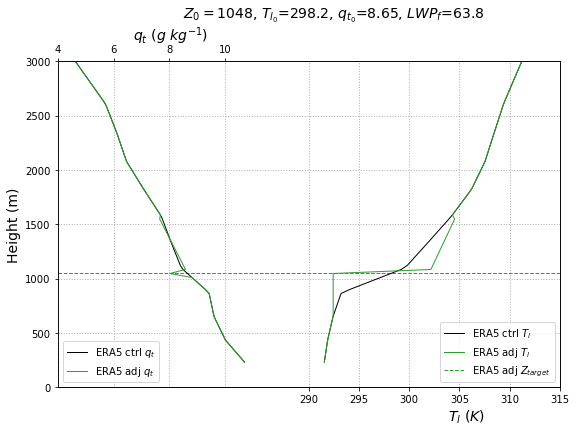

In [844]:
upbound = 3000 # upper bound (in meter) for the vertical integral
L_FT    = 500 # height above the inversion where ERA profiles don't "feel" the BL anymore
f_FT    = 3   # factor to determine the top of the region where we're fitting the line (zi + f_FT * L_FT ). 

CTH_0 = CTH_target = ERA_ZINV
Zi    = CTH_target
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi] 
QT_ML0 = ERA_qt[idx_zi]

run_and_plot()

Optimization terminated successfully.
         Current function value: 559.433007
         Iterations: 153
         Function evaluations: 279


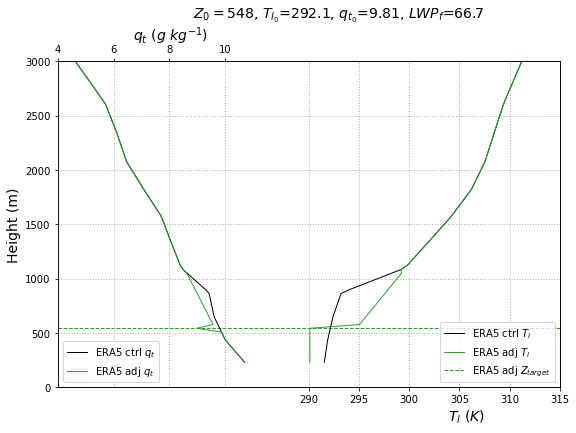

In [845]:
CTH_0 = CTH_target = ERA_ZINV - 500
Zi    = CTH_target
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi] 
QT_ML0 = ERA_qt[idx_zi]

run_and_plot()

Optimization terminated successfully.
         Current function value: 724.885894
         Iterations: 184
         Function evaluations: 335


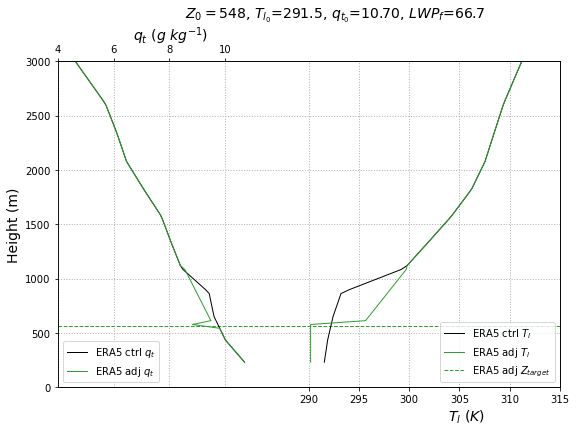

In [846]:
CTH_0 = CTH_target = ERA_ZINV - 500
Zi    = CTH_target
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi + 9] 
QT_ML0 = ERA_qt[idx_zi + 9]

run_and_plot()

Optimization terminated successfully.
         Current function value: 0.867555
         Iterations: 266
         Function evaluations: 473


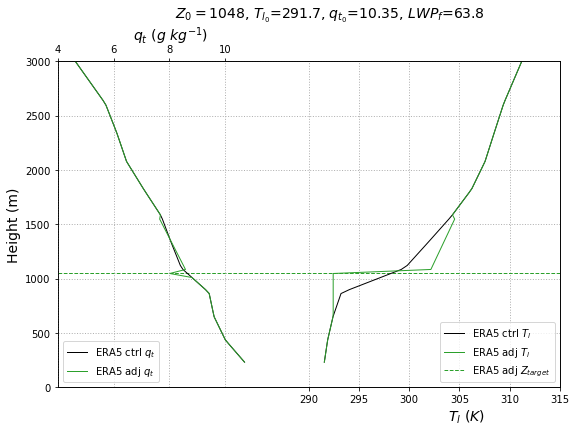

In [847]:
CTH_0 = CTH_target = ERA_ZINV
Zi    = CTH_target
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi + 20] 
QT_ML0 = ERA_qt[idx_zi + 20]

run_and_plot()

Optimization terminated successfully.
         Current function value: 0.867555
         Iterations: 269
         Function evaluations: 481


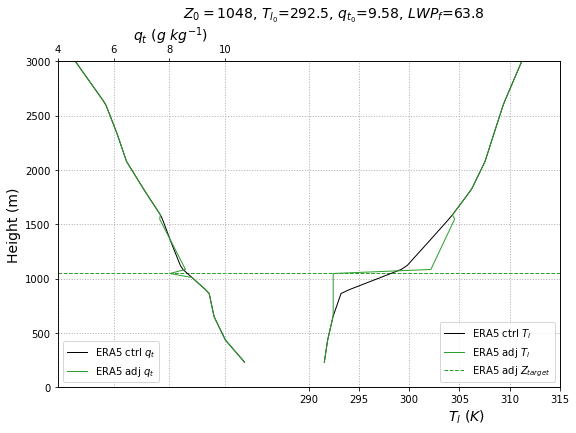

In [848]:
CTH_0 = CTH_target = ERA_ZINV
Zi    = CTH_target
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi + 10] 
QT_ML0 = ERA_qt[idx_zi + 10]

run_and_plot()

Optimization terminated successfully.
         Current function value: 0.867555
         Iterations: 173
         Function evaluations: 320


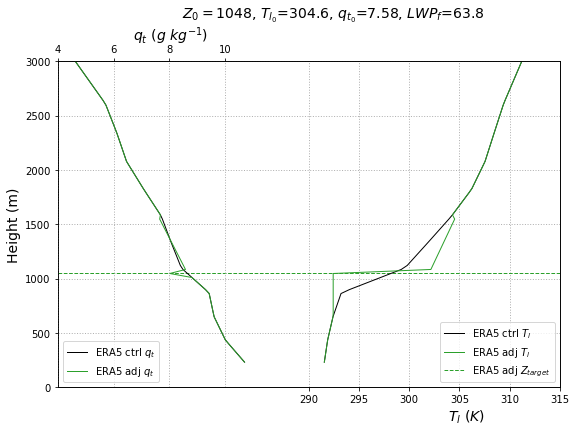

In [849]:
CTH_0 = CTH_target = ERA_ZINV
Zi    = CTH_target
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi - 15] 
QT_ML0 = ERA_qt[idx_zi - 15]

run_and_plot()

In [851]:
CTH_0  = CTH_target = MODIS_cth
Zi     = CTH_target
idx_zi = np.nanmax( np.where( abs(ERA_z - Zi) == np.nanmin(abs(ERA_z - Zi)) ) )
TL_ML0 = ERA_Tl[idx_zi]
QT_ML0 = ERA_qt[idx_zi]